In [1]:
import numpy as np
import matplotlib.pyplot as plt
from QEDcascPy_positrons import sim_positrons_angle,sim_rr_angle
from sklearn.gaussian_process.kernels import RBF,WhiteKernel
import gp_optimise
import importlib
import time
importlib.reload(gp_optimise)

<module 'gp_optimise' from '/home/cda523/Documents/Positrons/gp_optimise/gp_optimise.py'>

In [2]:
# Sim parameters
Npoints = 10
Nsims = 100
up_scale = 1e3
Nsamples = 1e3

In [3]:
# Expt parameters
Etot = 100 # J
gamma0 = 10e9/0.511e6
gamma_spread = 0.1 * gamma0

# Best compression
duration0 = 25 # fs
waist0 = 2*1.22*0.8 # microns

# Random jitter
t_std = 25e-15
r_std = 10e-6

# Electron energy scaling
gscale = 0.7

In [4]:
# Set up the variables etc
I0 = Etot/((duration0*1e-15)*(waist0*1e-6)**2) * (4*np.log(2)/np.pi)**1.5
a0 = np.sqrt(I0/2.1378e22)

In [5]:
# Define the MC functions to return positron number and rr rate
# Keep the offsets outside the function so I can use the same consistent offsets throughout

#dims = [{'name':'duration','type':'log-uniform','min':5,'max':100}]
dims = [{'name':'Esplit','type':'uniform','min':0,'max':1}]

z_offset = np.random.default_rng().normal(0, 0.5*t_std*3e8, Nsims)
x_offset = np.random.default_rng().normal(0, r_std, Nsims)
y_offset = np.random.default_rng().normal(0, r_std, Nsims)    
    
def estimate_positrons(params): # params = [Energy split]
    t0 = time.time()
    positron = np.zeros((Nsims))
    for i in range(Nsims):
        positron[i] = sim_positrons_angle(a0*np.sqrt(params[0]), gamma0*(1-params[0])**gscale, gamma_spread,angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],l0=0.0,
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")

    mu = np.mean(positron)
    sigma = np.std(positron)
    if mu<=0:
        mu = 1.0/(Nsamples*up_scale)**2
        sigma = 1.0/(Nsamples*up_scale)**1.5
        
    exponent = np.floor(np.log10(mu))
    t1 = time.time()
    print("Finished %0i sims in %0.2e s at %s=%0.2f, giving (%0.2f+-%0.2f)x10^%0i positrons per electron" 
          % (Nsims,t1-t0,dims[0]['name'],params[0],mu/10**exponent,sigma/np.sqrt(Nsims)/10**exponent,exponent))
        
    return np.log(mu**2/np.sqrt(mu**2+sigma**2)),np.sqrt(np.log(1+sigma**2/mu**2)/Nsims)
    
def estimate_rr(params): # params = [Energy split]

    rr = np.zeros(Nsims)
    for i in range(Nsims):
        rr[i] = sim_rr_angle(a0*np.sqrt(params[0]), gamma0*(1-params[0])**gscale, gamma_spread,angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")

    return np.mean(rr),np.std(rr)


In [6]:
params = [0.5]

positron = np.zeros((Nsims))
for i in range(Nsims):
    positron[i] = sim_positrons_angle(a0*np.sqrt(params[0]), gamma0*(1-params[0])**gscale, gamma_spread,angle=15, 
                            z_offset=z_offset[i], x_offset=x_offset[i], y_offset=y_offset[i],l0=0.0,
                            duration_fwhm = duration0*1e-15, waist_fwhm = waist0*1e-6,
                            Nsamples=Nsamples, up_scale=up_scale, model="Quantum")


Text(0, 0.5, 'Count')

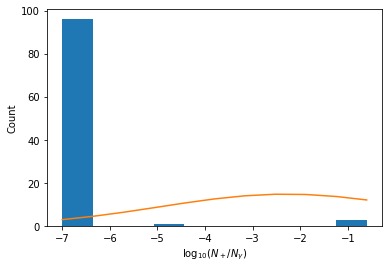

In [11]:
positron[positron==0] = 0.1*(Nsamples*up_scale)**-1
posmean = np.log(mu**2/np.sqrt(mu**2+sigma**2))
posstd = np.sqrt(np.log(1+sigma**2/mu**2))

npos,bins,patches = plt.hist(np.log(positron))
ngauss = Nsims/np.sqrt(2*np.pi*posstd**2)*np.exp(-0.5*((bins-posmean)/posstd)**2)
plt.plot(bins,ngauss)
plt.xlabel('log$_{10}(N_+/N_\gamma)$')
plt.ylabel('Count')

In [6]:
kernel = 1*RBF(length_scale_bounds=(1e-1, 1e1))# + WhiteKernel(noise_level_bounds=(1e-2, 1e0))
gpo = gp_optimise.Gp_optimise(estimate_positrons,dims,kernel)

In [7]:
gpo.initialise(Ninitial=5)

Finished 100 sims in 8.61e+02 s at Esplit=0.41, giving (1.27+-0.74)x10^-2 positrons per electron
Finished 100 sims in 5.56e+02 s at Esplit=0.25, giving (8.72+-5.09)x10^-3 positrons per electron
Finished 100 sims in 8.84e+02 s at Esplit=0.68, giving (1.16+-0.68)x10^-2 positrons per electron
Finished 100 sims in 5.83e+02 s at Esplit=0.82, giving (6.71+-3.92)x10^-3 positrons per electron
Finished 100 sims in 7.75e+02 s at Esplit=0.36, giving (1.18+-0.68)x10^-2 positrons per electron


/home/cda523/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:409: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning)


1.13**2 * RBF(length_scale=0.1)

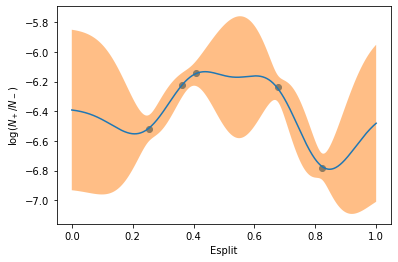

In [8]:
X_test = np.linspace(start=dims[0]['min'], stop=dims[0]['max'], num=1000).reshape(-1, 1)
y_test,std_test = gpo.gaussian_process.predict(X_test, return_std=True)
plt.scatter(gpo.X,gpo.y)
plt.plot(X_test,y_test)
plt.fill_between(X_test.ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
#plt.xscale('log')
plt.xlabel(dims[0]['name'])
plt.ylabel('log$(N_+/N_-)$')
gpo.gaussian_process.kernel_

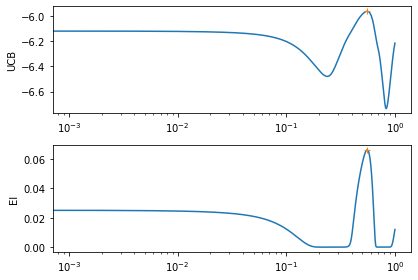

In [32]:
acq_test1 = gpo.acquisition_function(X_test,explore=1,acq_fn='UCB')
acq_test2 = gpo.acquisition_function(X_test,explore=0.01,acq_fn='EI')

nxt1 = gpo.next_acquisition(Nacq=100,explore=1,acq_fn='UCB')
nxt2 = gpo.next_acquisition(Nacq=100,explore=0.01,acq_fn='EI')

plt.subplot(2,1,1)
plt.plot(X_test,acq_test1)
plt.plot(nxt1,gpo.acquisition_function(nxt1,explore=1,acq_fn='UCB'),'+')
plt.xscale('log')
plt.ylabel('UCB')
plt.subplot(2,1,2)
plt.plot(X_test,acq_test2)
plt.plot(nxt2,gpo.acquisition_function(nxt2,explore=0.01,acq_fn='EI'),'+')
plt.xscale('log')
plt.ylabel('EI')
plt.tight_layout()

In [35]:
N_new = 1
gpo.optimise(N_new,Nacq=100,explore=0.01,acq_fn='EI')

Finished 100 sims in 9.83e+02 s at Esplit=0.56, giving (1.37+-0.80)x10^-2 positrons per electron


array([[0.51692684]])

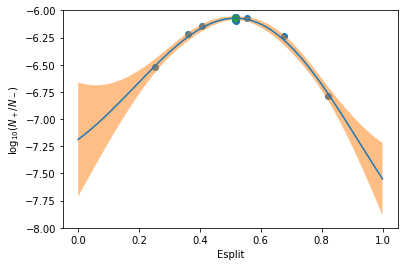

In [45]:
plt.scatter(gpo.X,gpo.y)
y_test,std_test = gpo.gaussian_process.predict(X_test, return_std=True)
plt.plot(X_test,y_test)
plt.fill_between(X_test.ravel(),y_test-2*std_test,y_test+2*std_test,alpha=0.5)
plt.scatter(gpo.X[-N_new:,0],gpo.y[-N_new:])
#plt.xscale('log')
plt.xlabel(dims[0]['name'])
plt.ylabel('log$_{10}(N_+/N_-)$')
plt.ylim([-8,-6])

acq_test2 = gpo.acquisition_function(X_test,explore=0.01,acq_fn='EI')
gpo.next_acquisition(Nacq=10,explore=0.01,acq_fn='EI')

In [41]:
np.savetxt('Esplit_example%i.txt'%(len(gpo.y)),np.transpose(np.vstack((gpo.X[:,0],gpo.y,gpo.yerr))),header='Esplit\tlog(N+/N-)\terror')
np.savetxt('Esplit_model%i.txt'%(len(gpo.y)),np.transpose(np.vstack((X_test[:,0],y_test,std_test))),header='Esplit\tlog(N+/N-)\terror')
np.savetxt('Esplit_acq%i.txt'%(len(gpo.y)),np.transpose(np.vstack((X_test[:,0],acq_test2))),header='Esplit\tEI')

In [42]:
for i in range(14):
    gpo.optimise(N_new,Nacq=100,explore=0.01,acq_fn='EI')
    acq_test2 = gpo.acquisition_function(X_test,explore=0.01,acq_fn='EI')
    np.savetxt('Esplit_example%i.txt'%(len(gpo.y)),np.transpose(np.vstack((gpo.X[:,0],gpo.y,gpo.yerr))),header='Esplit\tlog(N+/N-)\terror')
    np.savetxt('Esplit_model%i.txt'%(len(gpo.y)),np.transpose(np.vstack((X_test[:,0],y_test,std_test))),header='Esplit\tlog(N+/N-)\terror')
    np.savetxt('Esplit_acq%i.txt'%(len(gpo.y)),np.transpose(np.vstack((X_test[:,0],acq_test2))),header='Esplit\tEI')

Finished 100 sims in 9.55e+02 s at Esplit=0.52, giving (1.37+-0.80)x10^-2 positrons per electron
Finished 100 sims in 9.61e+02 s at Esplit=0.52, giving (1.38+-0.80)x10^-2 positrons per electron
Finished 100 sims in 9.55e+02 s at Esplit=0.52, giving (1.36+-0.79)x10^-2 positrons per electron
Finished 100 sims in 9.40e+02 s at Esplit=0.52, giving (1.34+-0.78)x10^-2 positrons per electron
Finished 100 sims in 9.57e+02 s at Esplit=0.52, giving (1.36+-0.79)x10^-2 positrons per electron
Finished 100 sims in 9.41e+02 s at Esplit=0.52, giving (1.33+-0.77)x10^-2 positrons per electron
Finished 100 sims in 9.40e+02 s at Esplit=0.52, giving (1.34+-0.79)x10^-2 positrons per electron
Finished 100 sims in 9.40e+02 s at Esplit=0.52, giving (1.34+-0.78)x10^-2 positrons per electron
Finished 100 sims in 9.56e+02 s at Esplit=0.52, giving (1.37+-0.80)x10^-2 positrons per electron
Finished 100 sims in 9.67e+02 s at Esplit=0.52, giving (1.38+-0.80)x10^-2 positrons per electron
Finished 100 sims in 9.48e+02 